## Figure 8. Comparing RDD for different network depths

Imports

In [1]:
!pwd

/Users/blansdel/projects/rdd


In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from lib.lif import LIF_Recurrent, ParamsLIF_Recurrent
from lib.causal import causaleffect_maxv, causaleffect_maxv_linear, causaleffect_maxv_sp

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [15]:
#Angle between two vectors
def alignment(a,b):
    da = np.dot(a,a)
    db = np.dot(b,b)
    if da > 0 and db > 0:
        return 180/np.pi*np.arccos(np.dot(a,b)/np.sqrt(da*db))
    else:
        return 360.
    
def mse(pred,true):
    return np.mean((pred - true)**2)

def tsplot(ax, data, xvals = None, **kw):
    if xvals is not None:
        x = xvals
    else:
        x = np.arange(data.shape[1])
    n = data.shape[0]
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)/np.sqrt(n)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

In [4]:
#Test LIF_Recurrent network
nsims = 1

cvals = [0.0, 0.3, 0.7]
pvals = np.logspace(-2, 0, 10)
#c = 0.9
n1 = 10
n2 = 10
tau_s = 0.020
dt = 0.001
t = 100    #In seconds
sigma = 10
x = 0
#p = 0.1
DeltaT = 10

nC = len(cvals)
nP = len(pvals)

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

params = ParamsLIF_Recurrent(exp_filter, sigma = sigma, n1 = n1, n2 = n2)
lif = LIF_Recurrent(params, t = t)

## Test 2 hidden layer network

In [5]:
results = lif.simulate()
np.nonzero(results[1][0,:])[0].shape

(3453,)

In [6]:
print('Firing rates:',np.sum(results[1], 1)/t)

Firing rates: [34.53 34.78 34.34 34.59 34.25 34.49 34.65 34.48 34.6  34.27 22.31 48.91
 14.94 22.19 26.01 55.7  20.63 36.16 56.99  8.18]


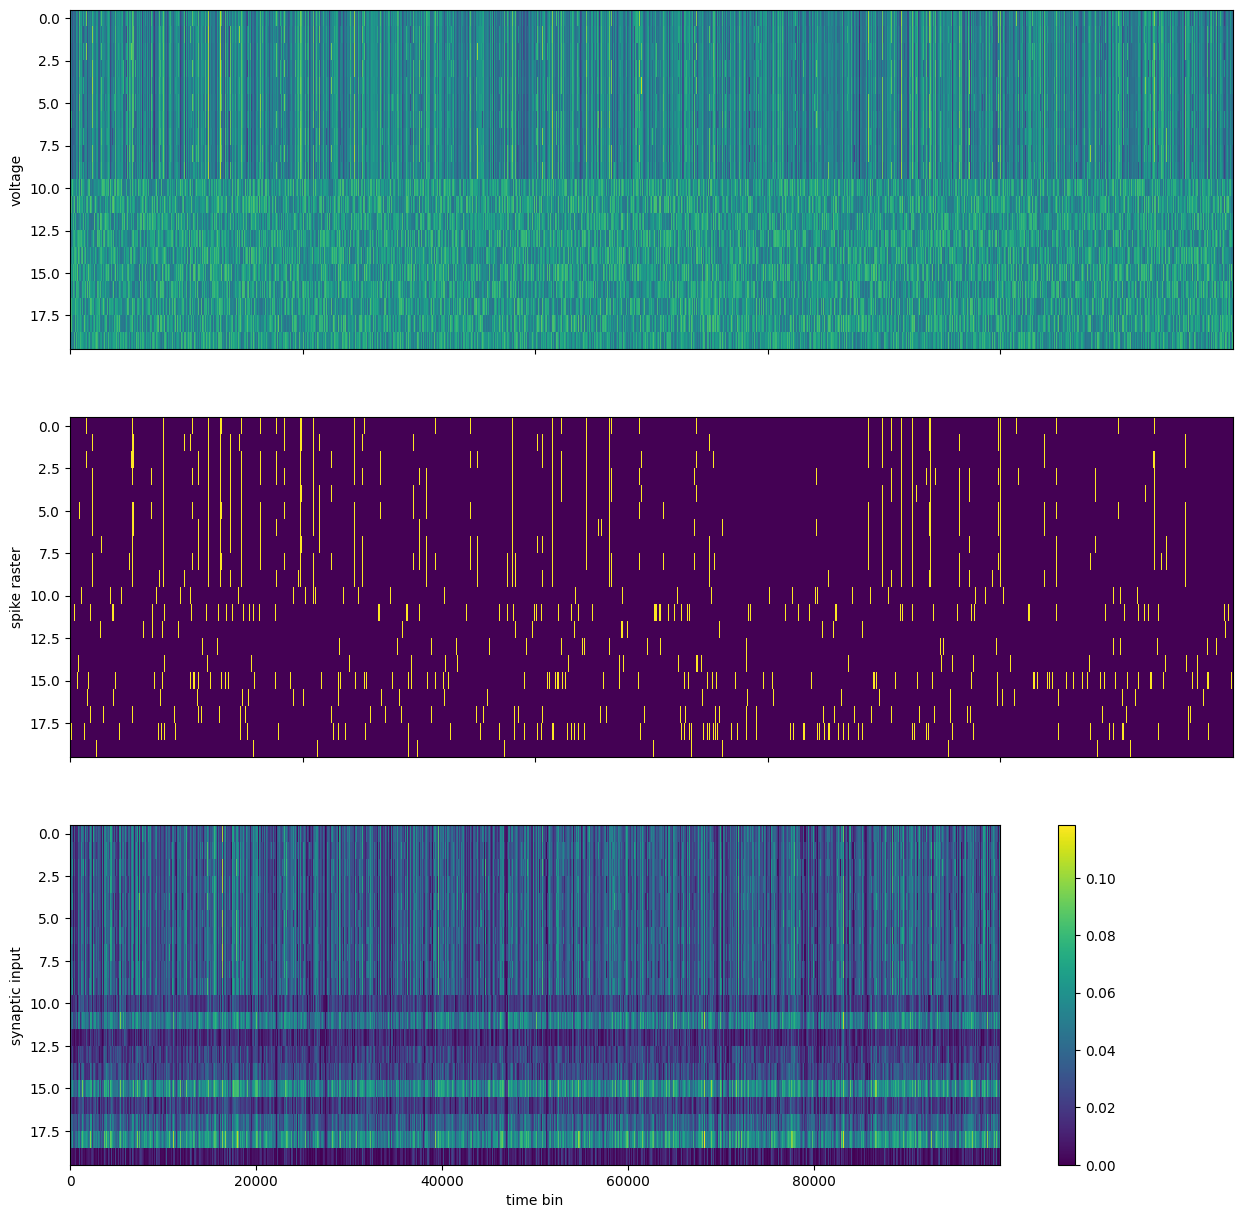

In [7]:
fig, axes = plt.subplots(3,1,figsize = (15, 15), sharex = True)
axes[0].imshow(results[0], aspect = 'auto', interpolation = 'nearest')
axes[1].imshow(results[1], aspect = 'auto', interpolation = 'nearest')
im2 = axes[2].imshow(results[3], aspect = 'auto', interpolation = 'nearest')
axes[0].set_ylabel('voltage')
axes[1].set_ylabel('spike raster')
axes[2].set_ylabel('synaptic input')
axes[2].set_xlabel('time bin')
plt.colorbar(im2, ax = axes[2])

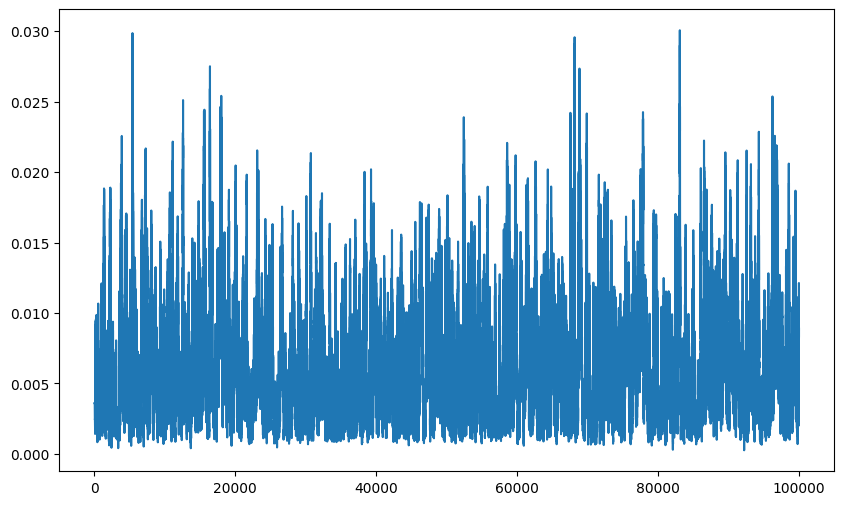

In [10]:
cost = C_orig(results[3][n1:,:])
plt.plot(cost)

## Causal effect estimation

In [9]:
U = np.eye(n2)
target = .02*np.ones((n2,1))
target[0] = 0
C_orig = lambda s: np.sum((np.dot(U, s) - target)**2,0)
nsims = 200
beta_rd_c = np.zeros((nC, nsims, nP, n1))
beta_rd_c_linear = np.zeros((nC, nsims, nP, n1))
beta_fd_c = np.zeros((nC, nsims, nP, n1))
beta_fd_c_linear = np.zeros((nC, nsims, nP, n1))

In [13]:
#Compute causal effects
for i,c in enumerate(cvals):
    print("Running %d simulations with c=%s"%(nsims, c))
    params.c = c
    lif.setup(params)
    for j in tqdm(range(nsims)):
        (v, h, u, sh) = lif.simulate(DeltaT)
        cost = C_orig(sh[n1:,:])
        for k,p in enumerate(pvals):
            #a = causaleffect_maxv(u[0:n1,:], cost, DeltaT, p, params)
            #print(a.shape)
            beta_rd_c[i,j,k,:] = causaleffect_maxv(u[0:n1,:], cost, DeltaT, p, params)
            beta_rd_c_linear[i,j,k,:] = causaleffect_maxv_linear(u[0:n1,:], cost, DeltaT, p, params)
        beta_fd_c[i,j,:] = causaleffect_maxv(u[0:n1,:], cost, DeltaT, 1, params)
        beta_fd_c_linear[i,j,:] = causaleffect_maxv_linear(u[0:n1,:], cost, DeltaT, 1, params)

Running 200 simulations with c=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [13:41<00:00,  4.11s/it]


Running 200 simulations with c=0.3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [13:13<00:00,  3.97s/it]


Running 200 simulations with c=0.7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [13:04<00:00,  3.92s/it]


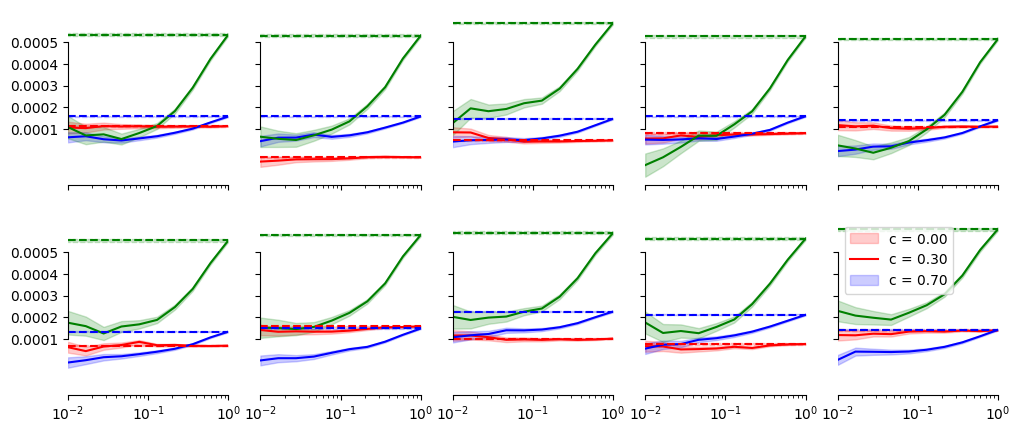

In [17]:
#Plot the causal effects as a function of p
fig,axes = plt.subplots(2,5,figsize=(12,5), sharex = True, sharey = True)

for u in range(10):
    #u = 1
    #for i in range(len(cvals)):
    #    #sns.tsplot(data = beta_rd_c[i,:,:,u], ax = ax, ci='sd', time=pvals)#, color='C%d'%i)
    #    sns.tsplot(data = beta_rd_c[i,:,:,u], ax = ax, time=pvals)#, color='C%d'%i)
    #    #ax.plot(pvals, m_beta_rd_c[i,-1,u]*ones(pvals.shape), '-.', color='C%d'%i)
    #sns.tsplot(data = beta_rd_c[0,:,:,u], ax = ax, time=pvals, color='red')
    i,j = divmod(u, 5)
    ax = axes[i,j]
    tsplot(ax, beta_rd_c[0,:,:,u], pvals, color='red')
    tsplot(ax, beta_rd_c[1,:,:,u], pvals, color='blue')
    tsplot(ax, beta_rd_c[2,:,:,u], pvals, color='green')
    tsplot(ax, beta_fd_c[0,:,:,u], pvals, color='red', linestyle = '--')
    tsplot(ax, beta_fd_c[1,:,:,u], pvals, color='blue', linestyle = '--')
    tsplot(ax, beta_fd_c[2,:,:,u], pvals, color='green', linestyle = '--')
    
    #tsplot(ax, beta_rd_c_linear[0,:,:,u], color='green')
    #tsplot(ax, beta_rd_c_linear[1,:,:,u], color='black')
    
    #ax.set_xlabel('window size $p$');
    #ax.set_ylabel('average causal effect');
    #ax.plot(pvals, beta_sp_c[0,u]*ones(pvals.shape), color=(0,0,0));
    #ax.set_ylim([3, 7])
    #ax.set_ylim([5.4, 5.9])
    #ax.set_xlim([0, 1])
    ax.set_xscale('log')
    #ax.set_xticks(pvals)
    sns.despine(trim=True)
ax.legend(["c = %.2f"%i for i in cvals]);
#plt.savefig('./fig_5.pdf')